<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/01.%EB%94%A5%EB%9F%AC%EB%8B%9Dwith%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0-basic/ch01_05_DNN%EA%B8%B0%EC%B4%88_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch01.05. 딥러닝 다중 분류 모델
---
* 날짜: 박태현
* 이름: 2022-07-04

## 학습내용
    - 딥러닝을 이용한 멀티클래스 분류 진행
    - 적절한 손실함수와 최적화 함수 정의
    - 평가 및 예측
    
## 학습자료

* 모두의딥러닝
* 데이터
  * `iris.csv`
  * MNIST 데이터셋


```
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)
```

```
https://github.com/yebiny/SkillTreePython-DeepLearning.git
```

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning.git

Cloning into 'SkillTreePython-DeepLearning'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 359 (delta 112), reused 120 (delta 78), pack-reused 178
Receiving objects: 100% (359/359), 22.36 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (147/147), done.


## 아이리스 꽃 종류 예측
---


```
- 0 sepal_length  꽃받침 길이
- 1 sepal_width 꽃받침 너비
- 2 petal_length 꽃임 길이
- 3 petal_width 꽃잎 너비
- 4 species 꽃의 종류 {setosa, versicolor virginica}
```
<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-01.PNG?raw=true width=550>
</p>


In [18]:
data_path = '/content/SkillTreePython-DeepLearning/dataset/iris.csv'
df = pd.read_csv(data_path, header = None)
df

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
def iris_preprocess(df, seed = 1):
  # x-y 분할
  x = df.values[:,:-1] # (전체 샘플, 마지막 변수 전까지)
  y = df.values[:,-1] # (전체 샘플, 마지막 변수)

  # 정규화 (x 데이터만)
  ss = StandardScaler()
  x = ss.fit_transform(x)

  # 원-핫 (y 데이터만)
  oh = OneHotEncoder(sparse = False)
  y = oh.fit_transform(np.expand_dims(y, 1)) # 인풋이 무조건 행렬 (150,) -> (150,1)
  print(f'원-핫 변환 순서 : {oh.categories_}')

  # train-test 분할
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,
                                                      random_state = seed,
                                                      stratify = y)
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = iris_preprocess(df)

print(f' 데이터 형태 : {x_train.shape}, {x_test.shape}, {y_train.shape}, {y_test.shape} ')
print(f' 첫 번째 샘플 x : {x_train[0]}, y : {y_train[0]} ')

원-핫 변환 순서 : [array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)]
 데이터 형태 : (105, 4), (45, 4), (105, 3), (45, 3) 
 첫 번째 샘플 x : [ 0.55333328 -0.58776353  0.76275864  0.39617188], y : [0. 0. 1.] 


* 예측값 분포 확인

Text(0.5, 1.0, 'test dataset')

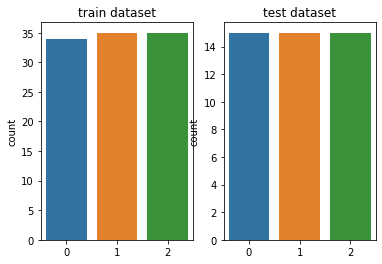

In [16]:
plt.subplot(121);sns.countplot(x = np.argmax(y_train, axis = 1));plt.title('train dataset')
plt.subplot(122);sns.countplot(x = np.argmax(y_test, axis = 1));plt.title('test dataset')

### | 모델


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-02.PNG?raw=true width=800>
</p>


#### **모델 생성**

In [23]:
from tensorflow.keras import models, layers, utils

def build_model():
  x = layers.Input(shape=(4,)) 
  z1 = layers.Dense(12, activation='relu')(x)
  z2 = layers.Dense(8, activation = 'relu')(z1)
  y = layers.Dense(3, activation='softmax')(z2)
  model = models.Model(x, y)
  return model

#### **모델 시각화**

* `model.summary()`
* `utils.plot_model()`

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 12)                60        
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 3)                 27        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


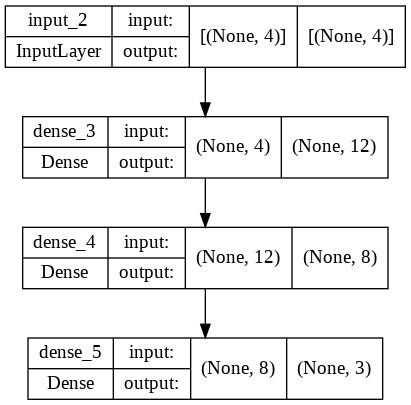

In [24]:
model = build_model()
model.summary()
utils.plot_model(model, show_shapes=True)

### | 학습

#### **모델 컴파일**

```
model.compile(loss, optimizer, metrics) 
```
* `loss` : 다중 분류 문제. 'categorical_crossentropy'
* `optimizer` : 문제와 상관없음. 'adam'
* `metrics`: accuracy (정확도)


In [26]:
model.compile(loss =  'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

#### **학습**

```
model.fit(x_train, y_train, epochs, batch_size)
```
* `x_train` : 넘파이 혹은 텐서 형식의 인풋 데이터
* `y_train` : 넘파이 혹은 텐서 형식의 아웃풋 데이터
* `epochs` : 학습 횟수
* `batch_size` : 배치 사이즈 ((업데이트 한번에 사용될 샘플 개수)

In [27]:
model.fit(x_train, y_train, epochs = 100, batch_size = 8)

Epoch 1/100
14/14 [==============================] - 4s 10ms/step - loss: 1.1313 - accuracy: 0.3333
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 1.0896 - accuracy: 0.3333
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 1.0574 - accuracy: 0.3333
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 1.0334 - accuracy: 0.3333
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 1.0095 - accuracy: 0.3429
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.9857 - accuracy: 0.3619
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.9585 - accuracy: 0.4381
Epoch 8/100
14/14 [==============================] - 0s 4ms/step - loss: 0.9297 - accuracy: 0.5333
Epoch 9/100
14/14 [==============================] - 0s 4ms/step - loss: 0.8998 - accuracy: 0.6000
Epoch 10/100
14/14 [==============================] - 0s 4ms/step - loss: 0.8662 - accuracy: 0.7714
Epoch 11

### | 검증 및 예측


#### **검증**

```
model.evaluate(x_test, y_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [28]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.1181 - accuracy: 0.9778


[0.11808124929666519, 0.9777777791023254]

#### **예측**

```
model.predict(x_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [31]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])
# 원핫 -> 라벨
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])

(45, 3) (45, 3)
[1. 0. 0.] [9.9971539e-01 2.8422585e-04 3.0232277e-07]
(45,) (45,)
0 0


* 예측 시각화

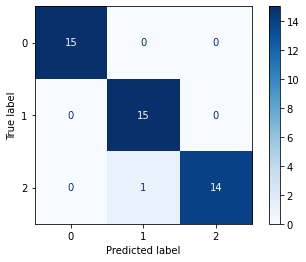

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
#print(cm)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

## 과제
---

### | 과제1. 다중분류 문제 정리

* 예측값의 범위 : 0~1
* 예측값의 shape : (input 개수, class 개수)
* 아웃풋 레이어의 노드 개수 : class 개수
* 아웃풋 레이어의 activation : softmax
* 손실함수 (loss) : Categorical_crossentropy
* 평가함수 (metrics) : accuracy

### | 과제2. 한 셀에 코드 정리하기

* 추가 연습
  * 모델의 깊이(depth)를 늘려가며 학습해 보세요.
  * 모델의 너비(width)를 늘려가며 학습해 보세요.

### | 과제 3. MNIST 숫자 데이터 분류

```
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
```

In [45]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 정규화 (x) 
x_train = x_train/255. # (0~1)
x_test = x_test/255.
# 원핫 (y) -> 안하고 작동시켜보기
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


* 데이터 시각화

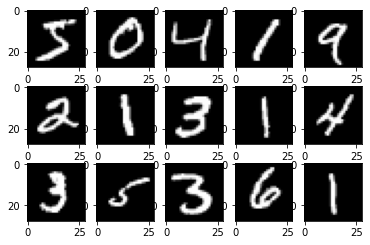

In [46]:
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(x_train[i], cmap='gray')

### | 모델


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-03.PNG?raw=true width=500>
</p>


#### **모델 생성**

In [77]:
from tensorflow.keras import models, layers, utils

def build_mnistmodel():
  x = layers.Input(shape=(28,28))
  y = layers.Flatten()(x)
  y = layers.Dense(256, activation='relu')(y)
  y = layers.Dense(256, activation='relu')(y)
  y = layers.Dense(10, activation='softmax')(y)

  model = models.Model(x, y)
  return model

#### **모델 시각화**

* `model.summary()`
* `utils.plot_model()`

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten_15 (Flatten)        (None, 784)               0         
                                                                 
 dense_36 (Dense)            (None, 256)               200960    
                                                                 
 dense_37 (Dense)            (None, 256)               65792     
                                                                 
 dense_38 (Dense)            (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


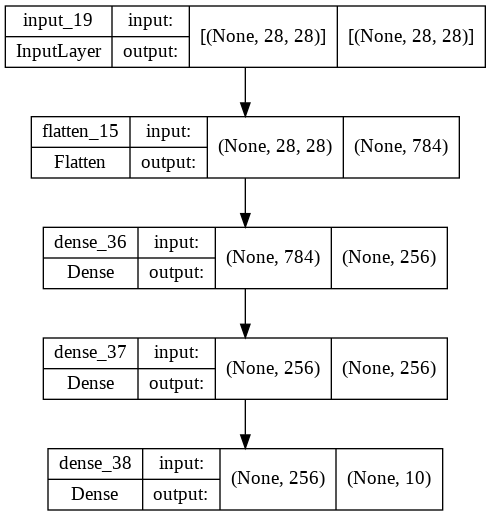

In [78]:
model = build_mnistmodel()
model.summary()
utils.plot_model(model, show_shapes=True)

### | 학습

#### **모델 컴파일**

```
model.compile(loss, optimizer, metrics) 
```
* `loss` : 원-핫 인코딩이 안 된 상태에서는 'sparse_categorical_crossentropy' 사용
* `optimizer` : 'adam'
* `metrics`: 'accuracy'


In [81]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

#### **학습**

```
model.fit(x_train, y_train, epochs, batch_size)
```
* `x_train` : 넘파이 혹은 텐서 형식의 인풋 데이터
* `y_train` : 넘파이 혹은 텐서 형식의 아웃풋 데이터
* `epochs` : 학습 횟수
* `batch_size` : 배치 사이즈 ((업데이트 한번에 사용될 샘플 개수)

In [84]:
model.fit(x_train, y_train, epochs = 10, batch_size = 16)

Epoch 1/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0196 - accuracy: 0.9943
Epoch 2/10
3750/3750 [==============================] - 9s 3ms/step - loss: 0.0179 - accuracy: 0.9951
Epoch 3/10
3750/3750 [==============================] - 9s 3ms/step - loss: 0.0178 - accuracy: 0.9951
Epoch 4/10
3750/3750 [==============================] - 9s 3ms/step - loss: 0.0153 - accuracy: 0.9959
Epoch 5/10
3750/3750 [==============================] - 9s 3ms/step - loss: 0.0163 - accuracy: 0.9958
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0176 - accuracy: 0.9954
Epoch 7/10
3750/3750 [==============================] - 9s 3ms/step - loss: 0.0146 - accuracy: 0.9958
Epoch 8/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.0157 - accuracy: 0.9962
Epoch 9/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.0154 - accuracy: 0.9963
Epoch 10/10
3750/3750 [==============================] - 9s 3ms/step - loss: 0

### | 검증 및 예측


#### **검증**

```
model.evaluate(x_test, y_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [85]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1702 - accuracy: 0.9798


[0.17023052275180817, 0.9797999858856201]

#### **예측**

```
model.predict(x_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [87]:
y_pred = np.argmax(model.predict(x_test), axis=1)

* 예측 시각화

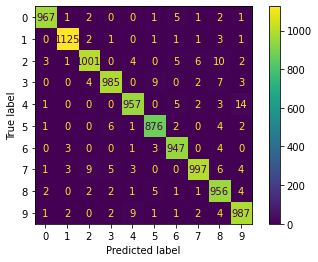

In [90]:
# 혼돈행렬 만들기
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion_matrix는 정수값이 들어가야함
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cm).plot();

* 모델 활용